# Visualizing ConvNet filters

In the last notebook, `6_visualise_convnets`, we visualized the activations of different layers in a pre-trained ConvNet. The activation of each channel was different, since we apply a different filter to get a resulting image channel. 

Another way to look at which patterns are recognized (activated) in which channels, is to visualize the actual filters. To do this, we'd have to turn around the roles a bit.. Instead of learning the filters, while passing input images, this time we'd fix the already trained filters and learn the image pixels. This is known as "gradient ascent in input space". The resulting input image will be one that the chosen filter is maximally responsive to.

How is this done? Well, we'll start by using random pixels of an image (just noise) and pass it through the ConvNet. Of course, we'll have to change the loss function, so that it's maximised when the input image matches the pattern the filter is most responsive to. The gradients of the loss regarding image pixels should then be calculated, and the image updated using these gradients. That's all.

In [2]:
from keras.applications import VGG16
from keras import backend as K

# Get the body of the ConvNet (excluding the flattened layers)
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Now we'd like to visualise a single filter in the network. Let's select a given layer, and a given filter, and define a loss function to be minimised.

In [6]:
layer_name = 'block3_conv1'
filter_index = 0

# Get the output of the given layer
layer_output = model.get_layer(layer_name).output
print(layer_output)

Tensor("block3_conv1/Relu:0", shape=(?, ?, ?, 256), dtype=float32)


We see that the selected output is a Tensor with 256 channels, and that the dimensions of the image at this stage are not defined (so we can pass in any image size).

In [36]:
loss = K.mean(layer_output[:, :, :, filter_index])

At this stage `loss` is just a definition of a tensor, and should get a value once data is passed inside the model. The next step is to calculate the gradient of this loss regarding the input image. This is also made easy with the method `gradients` in the `backend` module of Keras.

In [70]:
grads = K.gradients(loss=loss, variables=model.input)[0]

Normalizing the gradients by their L2 norm is a nice trick that would help the gradient descent move in the right direction and right amplitude. If we don't include this step, the gradient descent may not successfuly minimise the loss.

In [71]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

This last line simply means that we're calculating the gradient descent steps with regards to the `model.input`. Lastly, we can define the iterations using the `backend.function` method of Keras as follows.

In [72]:
iterate = K.function(inputs=[model.input], outputs=[loss, grads])

In [73]:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

The `iterate` method should now return a float value for the loss, and a matrix, of shape same as the input image, of the gradients.

In [81]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128  # adding some noise

learning_step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * learning_step

The values in the resulting tensor may not fall in the range [0, 255], and we need to postprocess it to get a displayable image. The following `deprocess_image` method will do the job.

In [67]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [82]:
img_ = deprocess_image(input_img_data[0])
img_.shape

(150, 150, 3)

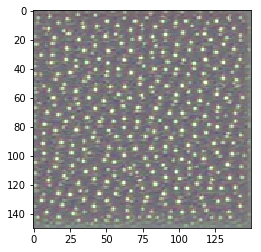

In [84]:
import matplotlib.pyplot as plt
plt.imshow(img_)
plt.show()

Ok so the selected filter activates on dotted pattern. We can put all of the above code in a function so it's easier to visualise different filters.